# Terrain Classification - General Data
### Created by Keenan McConkey 2019.8.12

In [1]:
from __future__ import absolute_import, division, print_function

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro']

# Columns not currently used for classification
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ', 'ACCELEROMETER XY (m/s²)']

'''Get columns for given label'''
def get_columns(label):
    # Columns differ for synthesis data
    if 'Middle' in label or 'Left' in label or 'Right' in label:
        columns = std_columns.copy()
    elif 'Synthesis' in label:
        columns = synthesis_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in label or 'PSD' in label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle', 'Synthesis']
transforms = ['FFT', 'PSDLog', 'PSD']
movements = ['F8', 'Donut', 'Straight']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
glob_paths = glob.glob('imu_data/new_setup/set_manual/*.csv')

# Remove 9250 IMU data (for now)
dataset_paths = [path for path in glob_paths if '9250' not in path]

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)
    
    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to easier to work with names
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in sec
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle frame data
    ## Can't remove from wheel-mounted Left and Right wheel data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Reorganize synthesis data columns to put Run Time and Epoch Time at the end
    if 'Synthesis' in dataset_label:
        dataset_columns = dataset.columns.tolist()
        dataset_columns = dataset_columns[:3] + dataset_columns[5:] + dataset_columns[3:5]
        dataset = dataset[dataset_columns]
    
    # Trim edges to account for start and end time
    STARTUP_THRESH = 2.0
    
    # Use different axes to check threshold for synthesis data
    if 'Synthesis' in dataset_label:
        thresh_axes = 'Calc X Accel'
    else:
        thresh_axes = 'Z Accel'
        
    # Caluclate first and last instance above threshold and use as the time domain
    start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[0]
    stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[-1]
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# Update order of synthesis columns
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro',
                     'Run Time', 'Epoch Time']

In [7]:
# Sort dictionary according to keys
raw_datasets = {label: raw_datasets[label] for label in sorted(raw_datasets.keys())}

# Save list of keys to variable
dataset_labels = list(raw_datasets.keys())
print('Number of raw datasets: {}'.format(len(dataset_labels)))

Number of raw datasets: 333


In [8]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
2971,-6.697752,-8.063040,2.459991,-0.721819,-0.570255,1.892346,8.915,1.565202e+09
2972,-7.295096,-8.195917,-0.677562,-0.720754,-0.548417,1.924037,8.918,1.565202e+09
2973,-6.226102,-7.138893,-2.937654,-0.666692,-0.510068,1.951202,8.921,1.565202e+09
2974,-5.175063,-7.549492,-1.483198,-0.668023,-0.519922,1.974638,8.924,1.565202e+09
2975,-4.813545,-7.622514,2.151144,-0.694921,-0.514595,2.010058,8.927,1.565202e+09


### Part (b) - Visualizing Time Domain Data

In [9]:
'''Plot a single Pandas dataset for given x and y axes'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    # Figure parameters
    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    # Add relevant units to y label
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    elif 'Vel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s$)')
    else:
        plt.ylabel('Unknown')
    
    # Use limits if they've been passed in
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Plot relevant data
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

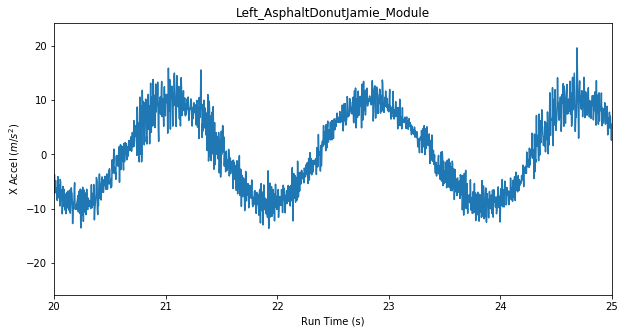

In [10]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'X Accel', xlim=(20, 25))

In [11]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [12]:
'''Compare two Pandas datasets by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, y_axis, t_offset=0, y_offset=0):
    # Plot parameters
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_title(y_axis + ' for ' + label1 + ' and ' + label2)
        
    # Add relevant units to y label
    if 'Gyro' in y_axis:
        ax.set_ylabel(y_axis + ' ($rad/s$)')
    elif 'Accel' in y_axis:
        ax.set_ylabel(y_axis + ' ($m/s^2$)')
    elif 'Vel' in y_axis:
        ax.set_ylabel(y_axis + ' ($m/s$)')
    else:
        ax.set_ylabel('Unknown')
    
    # Plot data with given y and t offsets applied to first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][y_axis].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][y_axis], label=label2)
    
    # Include offset info text in plot
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [13]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_ConcreteStraightKevin_Module',
#                raw_datasets, 'Right_ConcreteStraightKevin_Module', 
#                dirn='Z Gyro')

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    # Set paramaeters based on number of datasets to plot
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 0
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
    axes = []
    row, col = 0, 0
    
    # Plot each of the given datasets
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

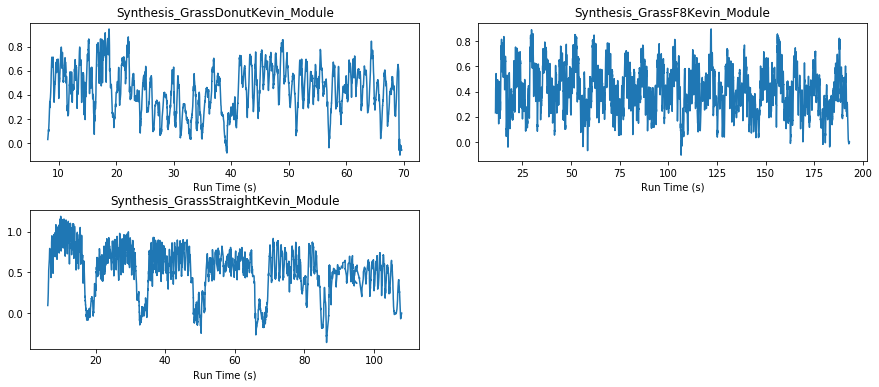

In [15]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Synthesis' in label and 'Grass' in label and 'Kevin' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='Calc X Vel')

### Part (c) - Converting Between Pandas and Numpy

In [16]:
'''Convert array of Pandas DataFrames to array of 2D NumPy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    # Convert each dataset individually
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [17]:
'''Convert array of 2D NumPy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    # Convert each dataset individually
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))     
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [18]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [19]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 333
Shape of first dataset: (20222, 8)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Preprocessing

In [21]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label')
        
    return f_samp, f_low, f_high

In [22]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    # Sampling frequency differs varies between frame and wheel modules
    # Synthesis data is created from combining left and right wheel data so it has the same samp rate
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label')
        
    return window_size

In [23]:
'''Get number of data columns in dataset with given label'''
def get_n_data_col(label):
    # Different number of columns for Synthesis datasets
    if 'Synthesis' in label:
        n_col = 17
    elif 'Left' in label or 'Right' in label or 'Middle' in label:
        n_col = 6
    else:
        raise Exception('Unknown label')
    return n_col

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

**Nominally set to 30 % of Nyquist Freq**

In [24]:
# Filtered datasets dictionary
datasets = {}

# Filter each dataset individually
for label, raw_dataset in raw_datasets.items():
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Number of columns containing data
    n_data_col = get_n_data_col(label)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(n_data_col):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, dataset[:, i])
        
    datasets.update({label: dataset})

In [25]:
# Check construction of filtered dataset
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 333
Shape of first filtered dataset: (20222, 8)


In [26]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
0,-6.698429,-8.063168,2.458648,-0.721819,-0.570230,1.892358,8.915,1.565202e+09
1,-6.528537,-7.894444,-0.583850,-0.693312,-0.545581,1.920505,8.918,1.565202e+09
2,-6.135618,-7.666894,-1.829945,-0.677845,-0.526474,1.948840,8.921,1.565202e+09
3,-5.608335,-7.356281,-0.994583,-0.682656,-0.512938,1.978671,8.924,1.565202e+09
4,-5.247871,-7.025428,0.649326,-0.704289,-0.501146,2.011160,8.927,1.565202e+09


<Figure size 432x288 with 0 Axes>

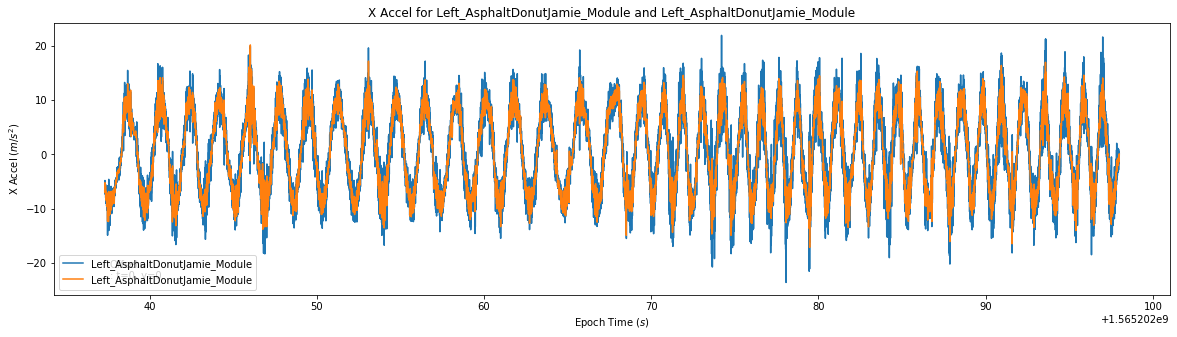

In [27]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'X Accel')

### Part (b) - Further Time Domain Visualization

In [28]:
'''Compare Z Gyro of frame to Z Gyro calculated by combining wheel data, for Pandas data'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro using wheel data
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [29]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [30]:
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Total windows that fit in the dataset
    n_points = n_windows * window_size # Total number of points that fit in non-overlapping windows
    
    # Windowed data
    dataset_windowed = []
    
    # Iterate through dataset by half a window at a time and extract windows
    i = 0
    window_slide = int(window_size / 2)
    
    while (i < n_points):
        dataset_windowed.append(dataset[i:i + window_size])
        i += window_slide
    
    datasets_windowed.update({label: dataset_windowed})

In [31]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 333
Num of windows in first dataset: 121
Shape of individual window: (333, 8)


In [32]:
# Try out Pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
328,-0.761103,10.857539,0.452852,0.050812,0.467124,3.293363,9.899,1.565202e+09
329,-0.717929,10.717496,1.784095,0.054129,0.471190,3.324165,9.902,1.565202e+09
330,-0.491972,10.458396,1.649796,0.054505,0.472238,3.358083,9.905,1.565202e+09
331,-0.148952,10.471219,0.076395,0.061051,0.475071,3.392778,9.908,1.565202e+09
332,0.113552,10.805944,-1.311798,0.077564,0.484073,3.424948,9.911,1.565202e+09


<Figure size 432x288 with 0 Axes>

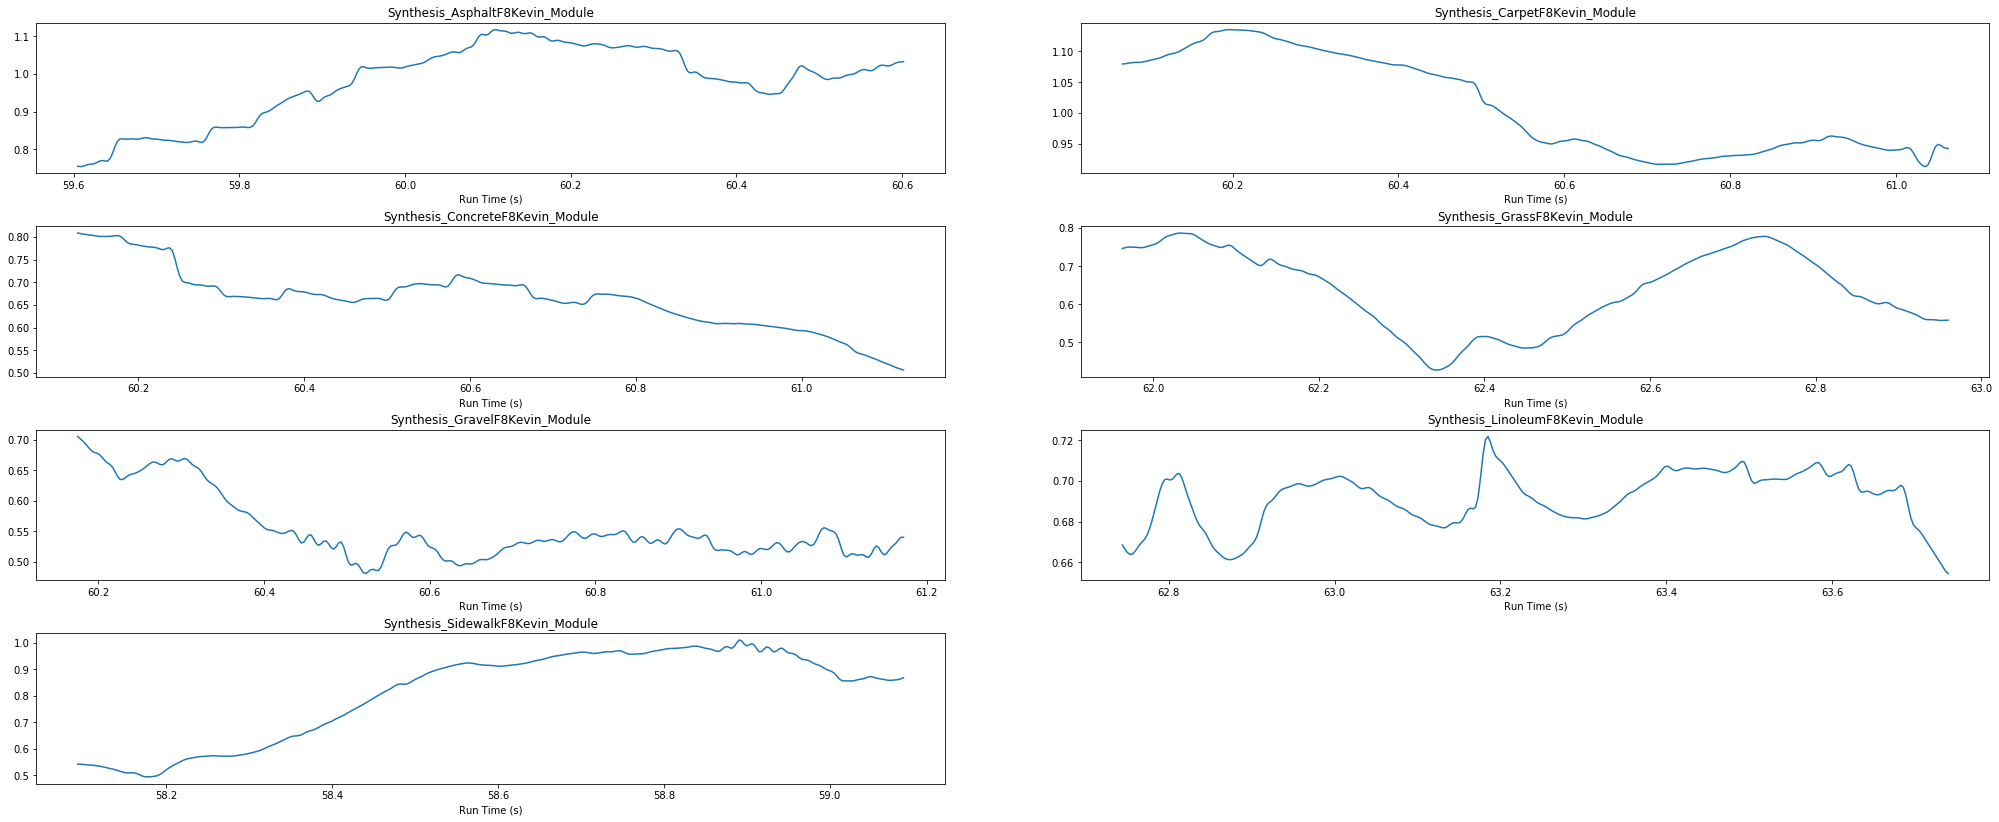

In [33]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Synthesis' in label and 'F8' in label and 'Kevin' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Calc X Vel', windowed=True, win_num=102)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [ ]:
# Butterworth filter bandpass isn't a perfect edge so there is still some relevant data past the cutoff
N_BINS_OVER_CUTOFF = 5

In [34]:
'''Plot transform of given direction and window of a windowed NumPy dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + ', Window {}'.format(win_num))
    plt.show()

### Part (a) - FFT

In [35]:
datasets_fft = {}

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Get relevant parameters for given label
        f_samp, f_low, f_high = get_frequencies(label)        
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, n_data_col))
        
        for i in range(n_data_col):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + '_FFT': dataset_fft})

In [36]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'_FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'_FFT'][0].shape))

# Test Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'_FFT'][0].head()

Num of FFT'd windowed datasets: 333
Num of FFT'd windows in first dataset: 348
Shape of FFT'd individual window: (64, 7)


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,6.333740,4.292461,0.144244,0.533097,0.167732,2.363399,0.000000
1,1.732127,2.682901,0.036650,0.230266,0.130634,0.133853,1.000901
2,0.581895,1.430385,0.111187,0.015819,0.121918,0.033870,2.001802
3,0.262913,1.075483,0.044565,0.068944,0.050837,0.048282,3.002703
4,0.245442,0.887364,0.039754,0.051774,0.029840,0.074794,4.003604


<Figure size 432x288 with 0 Axes>

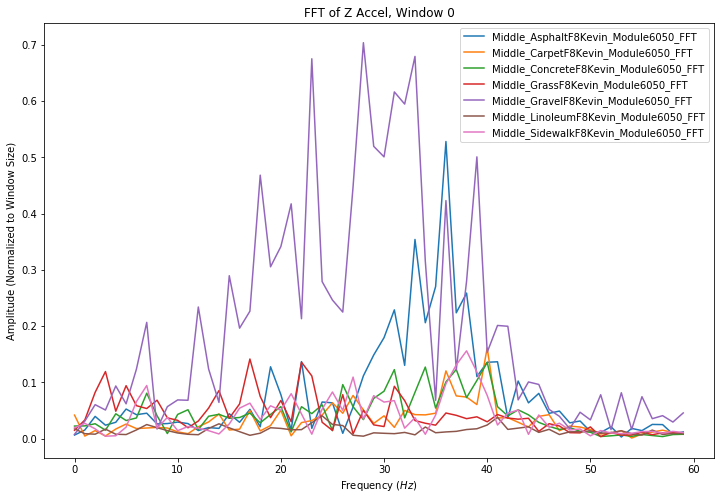

In [37]:
# Compare some FFTs
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_set_transforms(ffts_to_plot, win_num=0, dirn=2, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

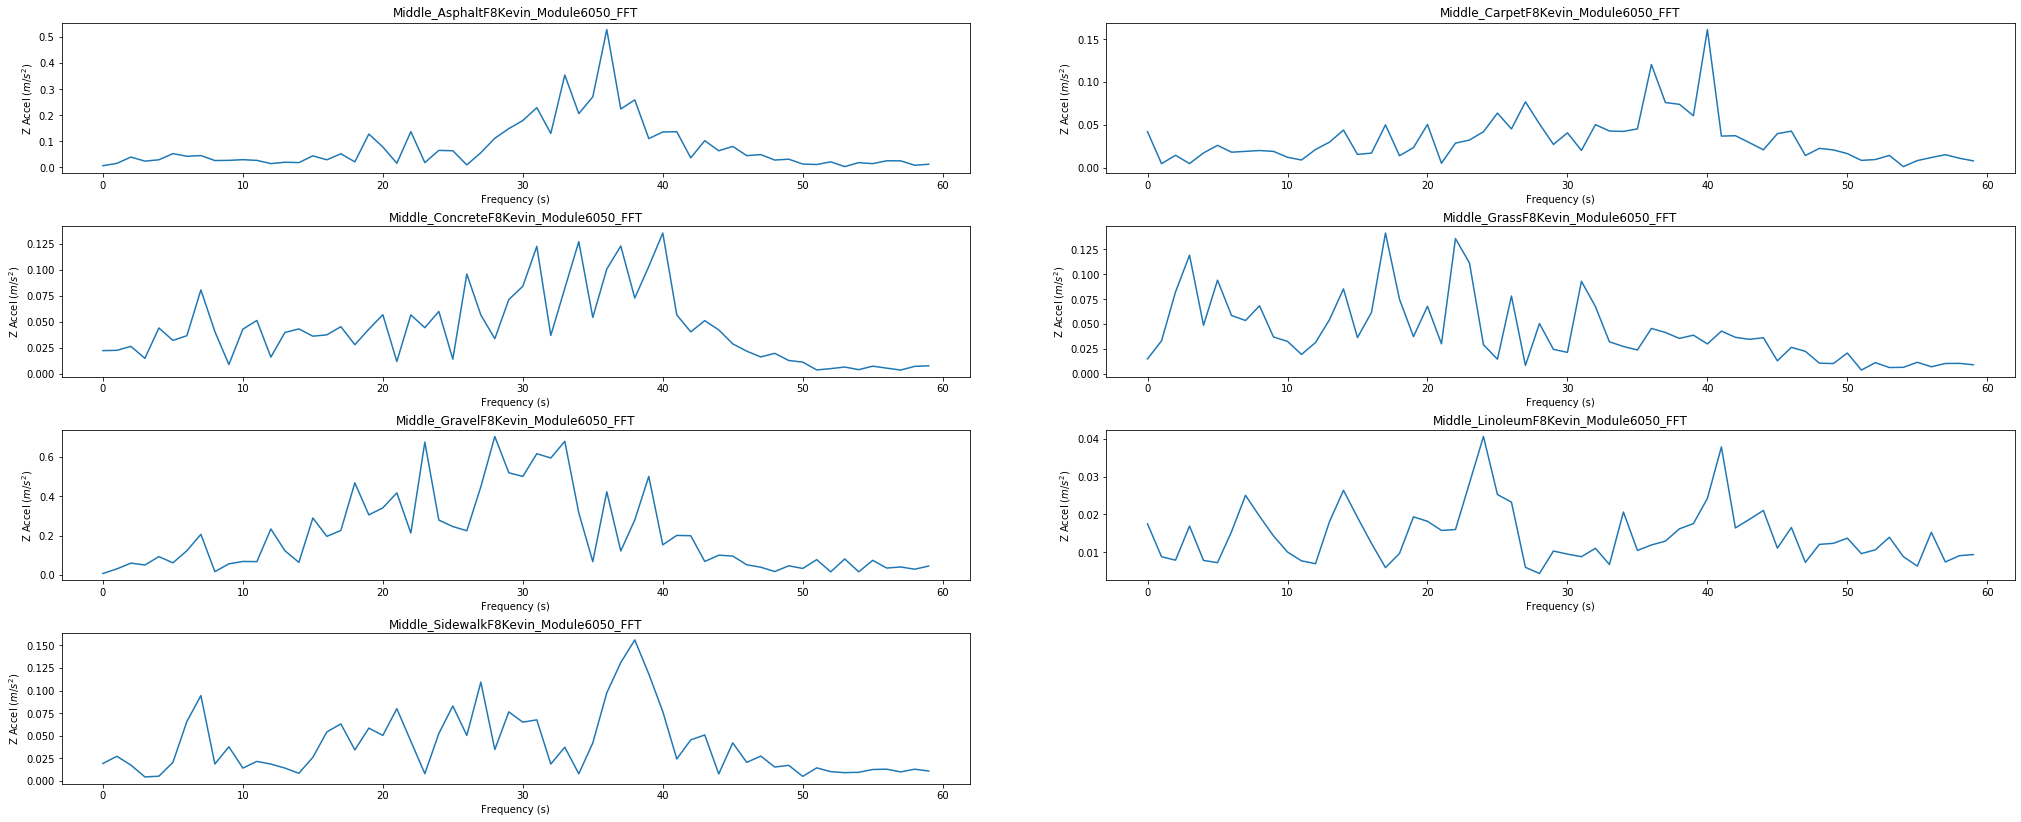

In [38]:
# Compare some FFTs
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Z Accel', windowed=True)

### Part (b) - PSD

In [39]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, n_data_col))
        window_psd_log = np.zeros((n_bins, n_data_col))
        
        # Calculate PSD for each axes
        for i in range(n_data_col):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + '_PSD': dataset_psd})
    datasets_psd_log.update({label +'_PSDLog': dataset_psd_log})

In [40]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'_PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'_PSD'][0].shape))

Num PSD'd windowed datasets: 333
Num of PSD'd windows in first dataset: 121
Shape of PSD'd individual window: (64, 7)


<Figure size 432x288 with 0 Axes>

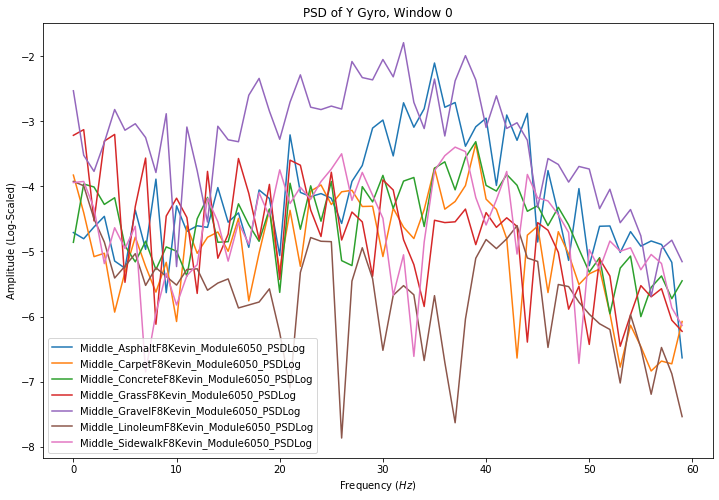

In [41]:
# Compare some Log PSDs
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=4, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

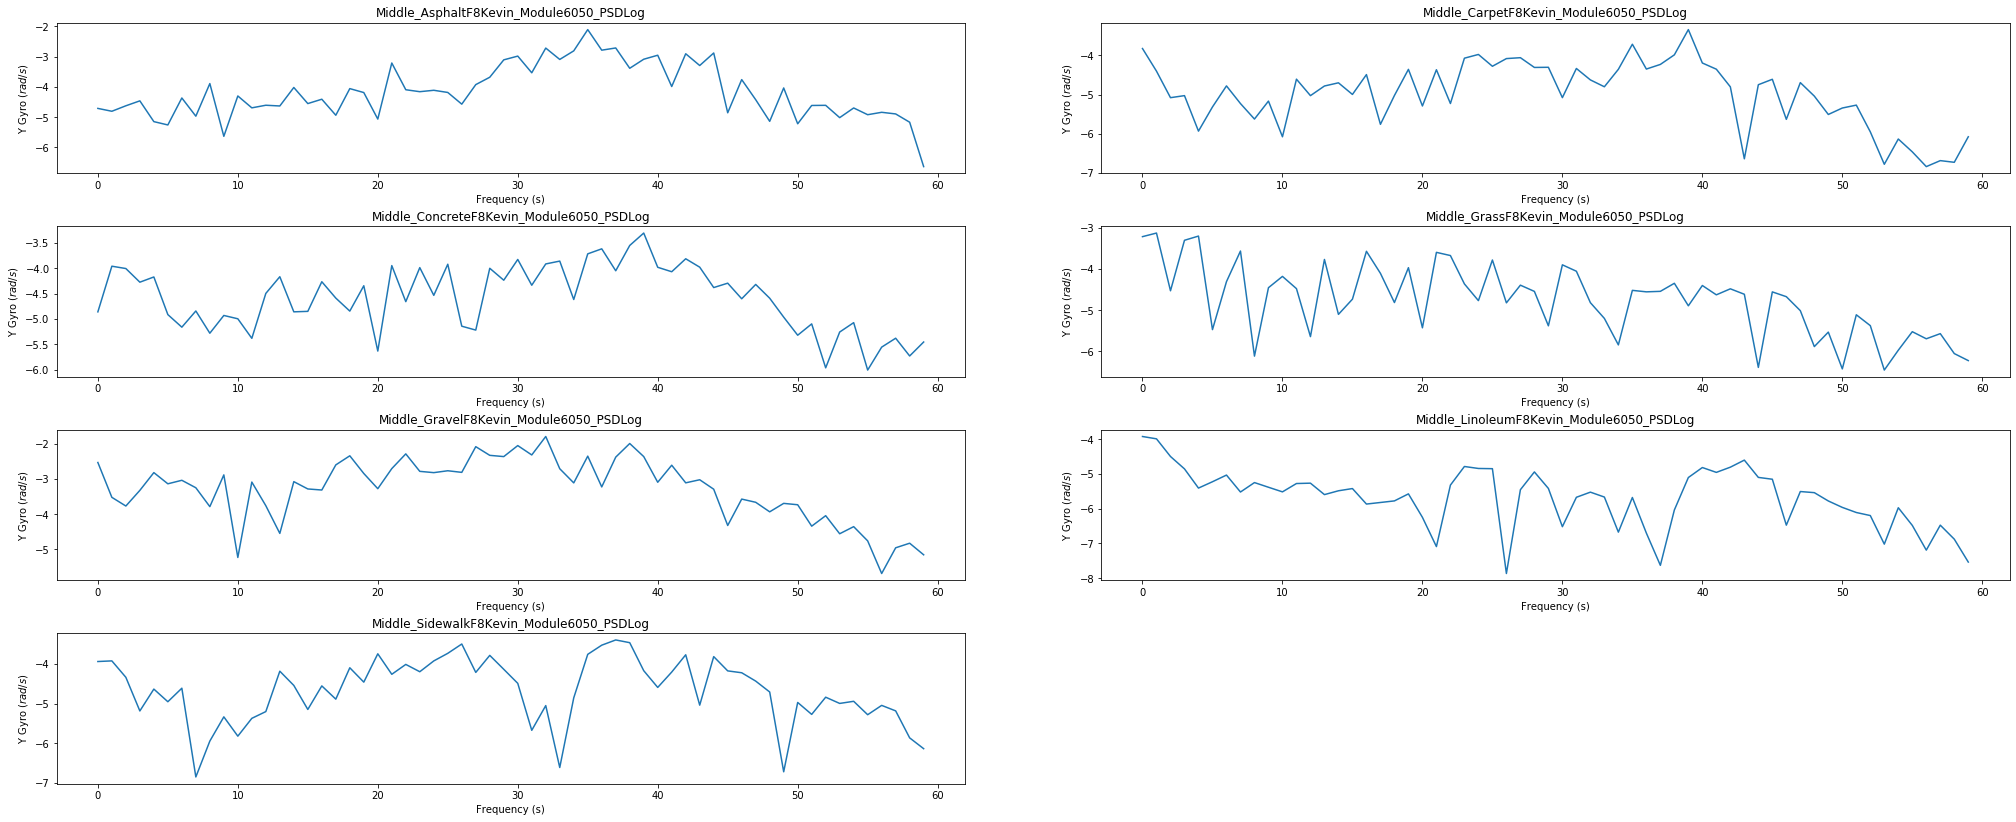

In [42]:
# Compare some Log PSDs
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='Y Gyro', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [43]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific plot parameters for different transforms
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Frequency ($Hz$)')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
        
        # TODO: Make this nicer
        ax.set_title(transform_name + ' of ' + get_columns(label)[dirn] + ', Window {}')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

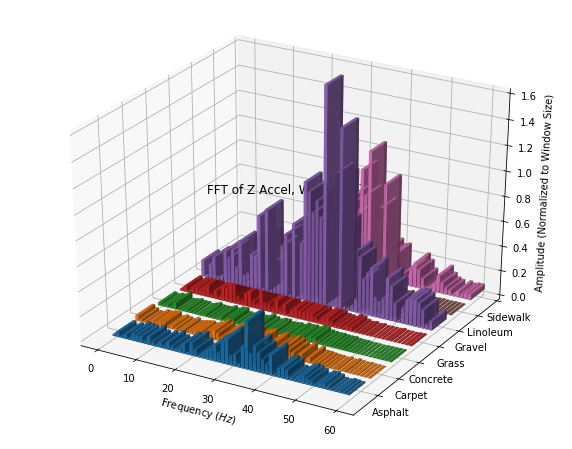

In [44]:
# Compare some FFTs in 3D
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_transforms_3d(ffts_to_plot, win_num=4, dirn=2, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

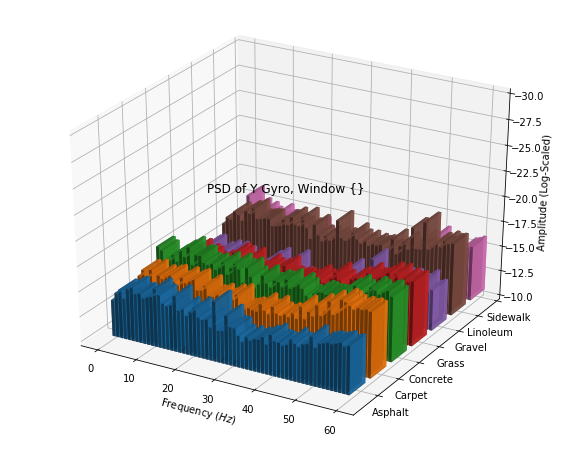

In [45]:
# Compare some PSDs in 3D
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_transforms_3d(psds_to_plot, win_num=4, dirn=4, transform_name='PSD')

### Part (d) - Spectograms

In [46]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(get_columns(set_label)[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

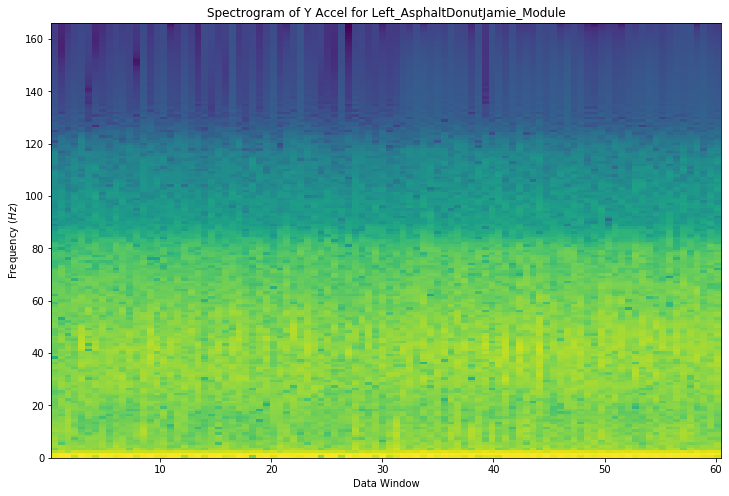

In [47]:
plot_spectogram(dataset_labels[0], dirn=1, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

#### Extract possibly relevant features (e.g. Mean, Min, Skew) from each data window

In [48]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Find locations where array > 0, put -1 and 1 for each rising/falling point from 0,
    # divide by total datapoints in window
    return len(np.nonzero(np.diff(array > 0.0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freqs, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freqs, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [49]:
'''Extract given features from column of each dataset
   Converts a dictionary of datasets to a nested dictionary where each dataset has its own dictionary
   of axes/directions'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        n_data_col = get_n_data_col(label)
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:n_data_col]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window        
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('_PSD', ''): directions})
    
    return datasets_feat

In [50]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
    
    # Set limits if they've been given
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [51]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std': np.std,  'Norm': l2norm, 'AC': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'RMS': rms, 'ZCR': zcr, 
                 'Skew': stats.skew, 'EK': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


In [52]:
# Check if feature data is constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Accel'].shape))

Num datasets: 333
Num directions: 6
Shape of first dataset first direction: (121, 10)


<Figure size 432x288 with 0 Axes>

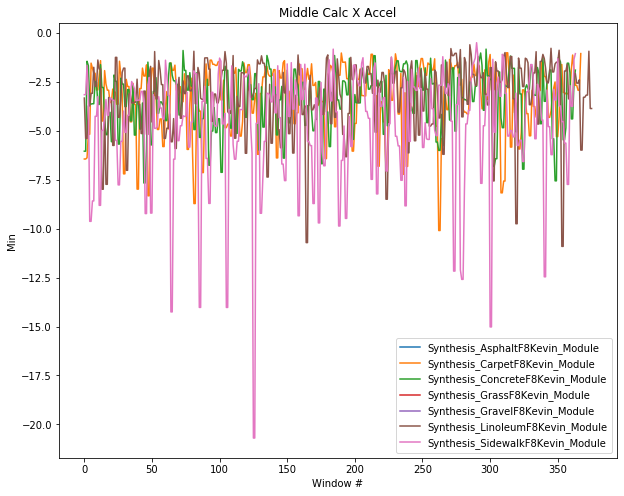

In [53]:
# Plot some time feature data
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Synthesis' in label and 'F8' in label and 'Kevin' in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [54]:
# Frequency domain feature functions and names
freq_features = {'MSF': msf, 'RMSF': rmsf, 'FC': fc, 'VF': vf, 'RVF': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [55]:
# Check if feature data is constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Accel'].shape))

Num datasets: 333
Num directions: 6
Shape of one direction: (121, 5)


<Figure size 432x288 with 0 Axes>

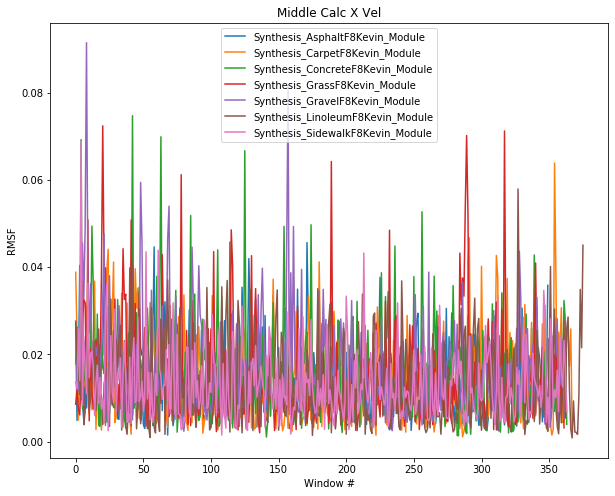

In [56]:
# Plot some frequency feature data
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Synthesis' in label and 'F8' in label and 'Kevin' in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Vel', feat_name='RMSF', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Standardization, Columning, and Combining Datasets

In [57]:
# Convert transform data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [58]:
# Add time and frequency features together
datasets_feat = {}

# Add together for each dataset
for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [59]:
# Check formatting, again...
datasets_feat[dataset_labels[0]]['X Accel'].head()

,Mean,Std,Norm,AC,Max,Min,RMS,ZCR,Skew,EK,MSF,RMSF,FC,VF,RVF
0,-6.333740,2.799001,126.362857,15967.571542,0.113552,-12.370650,6.924642,0.003003,0.325974,-0.815695,0.169172,0.411305,3.354634,-11.084398,0.411305
1,1.653583,6.497414,122.346200,14968.592540,12.992936,-9.038265,6.704530,0.009009,0.106563,-1.529988,0.757407,0.870292,1.310311,-0.959508,0.870292
2,5.929635,3.250590,123.397976,15227.060494,12.992936,-1.152094,6.762167,0.015015,-0.069202,-0.881793,0.247530,0.497524,3.280576,-10.514647,0.497524
3,-1.456939,6.265167,117.379173,13777.870183,11.813090,-12.142184,6.432339,0.009009,0.034055,-1.475442,0.767147,0.875869,1.875692,-2.751076,0.875869
4,-5.760124,3.414559,122.193023,14931.134824,3.935042,-12.142184,6.696136,0.003003,0.894977,0.384612,0.270925,0.520504,3.098056,-9.327024,0.520504


### Part (a) - Columning Data

Combine IMU data from each direction into single dataframes with columns for each feature in each direction

In [60]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

#### Part (i) - Extracted Featured Data

In [61]:
'''Combined directions (axes) of a featured dataset'''
def combine_extracted_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [62]:
# Take frame data and combine directions
datasets_feat_columned = combine_extracted_columns(datasets_feat)

# Confirm formatting
datasets_feat_columned[dataset_labels[0]].head()

,Mean X Accel Left,Std X Accel Left,Norm X Accel Left,AC X Accel Left,Max X Accel Left,Min X Accel Left,RMS X Accel Left,ZCR X Accel Left,Skew X Accel Left,EK X Accel Left,...,Min Z Gyro Left,RMS Z Gyro Left,ZCR Z Gyro Left,Skew Z Gyro Left,EK Z Gyro Left,MSF Z Gyro Left,RMSF Z Gyro Left,FC Z Gyro Left,VF Z Gyro Left,RVF Z Gyro Left
0,-6.333740,2.799001,126.362857,15967.571542,0.113552,-12.370650,6.924642,0.003003,0.325974,-0.815695,...,1.892358,2.380132,0.0,1.507718,2.057499,0.008964,0.094677,4.493900,-20.186172,0.094677
1,1.653583,6.497414,122.346200,14968.592540,12.992936,-9.038265,6.704530,0.009009,0.106563,-1.529988,...,2.036325,3.200487,0.0,-0.165735,-1.796213,0.006717,0.081955,0.613786,-0.370016,0.081955
2,5.929635,3.250590,123.397976,15227.060494,12.992936,-1.152094,6.762167,0.015015,-0.069202,-0.881793,...,2.376084,3.344198,0.0,-0.248861,-1.567967,0.001408,0.037523,0.201643,-0.039252,0.037523
3,-1.456939,6.265167,117.379173,13777.870183,11.813090,-12.142184,6.432339,0.009009,0.034055,-1.475442,...,2.376084,2.973163,0.0,-0.733669,-0.903730,0.006834,0.082666,0.675241,-0.449117,0.082666
4,-5.760124,3.414559,122.193023,14931.134824,3.935042,-12.142184,6.696136,0.003003,0.894977,0.384612,...,2.860065,3.222971,0.0,1.060128,0.443970,0.007947,0.089145,1.105274,-1.213684,0.089145


#### Part (ii) - Transformed Data

In [64]:
'''Combined direction (axes) columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        # Get frequency bins from frequency column of first window
        freq_bins = dataset[0]['Frequency'].tolist()
        
        # Get more parameter for current label
        data_cols = get_columns(label)[:get_n_data_col(label)]
        trans = get_transform(label)
        place = get_placement(label)
        
        # Combine parameters to form columns for new combined DataFrame
        new_cols = [trans + ' {} Hz '.format(round(f_bin)) + d_col + ' ' + place for d_col in data_cols for f_bin in freq_bins]
        
        # Convert windowed arrays into a single array with each window as a row
        new_data = []
        
        for window in dataset:
            new_row = []
            for d_col in data_cols:
                new_row.extend(window[d_col].tolist())
            new_data.append(new_row)
            
        # Create new DataFrame
        combined_df = pd.DataFrame(data=new_data, columns=new_cols)
        combined_datasets.update({label: combined_df})

    return combined_datasets

In [65]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [66]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [67]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + '_FFT'].head()

,FFT 0 Hz X Accel Left,FFT 1 Hz X Accel Left,FFT 2 Hz X Accel Left,FFT 3 Hz X Accel Left,FFT 4 Hz X Accel Left,FFT 5 Hz X Accel Left,FFT 6 Hz X Accel Left,FFT 7 Hz X Accel Left,FFT 8 Hz X Accel Left,FFT 9 Hz X Accel Left,...,FFT 54 Hz Z Gyro Left,FFT 55 Hz Z Gyro Left,FFT 56 Hz Z Gyro Left,FFT 57 Hz Z Gyro Left,FFT 58 Hz Z Gyro Left,FFT 59 Hz Z Gyro Left,FFT 60 Hz Z Gyro Left,FFT 61 Hz Z Gyro Left,FFT 62 Hz Z Gyro Left,FFT 63 Hz Z Gyro Left
0,6.333740,1.732127,0.581895,0.262913,0.245442,0.147013,0.223646,0.108940,0.104232,0.073182,...,0.004815,0.004540,0.004504,0.004483,0.004714,0.004652,0.004582,0.004111,0.004302,0.004248
1,1.653583,4.014842,1.357264,1.078955,0.759555,0.455978,0.426564,0.376261,0.291122,0.178050,...,0.003759,0.003852,0.003579,0.004279,0.004114,0.003273,0.003892,0.003788,0.003288,0.003577
2,5.929635,1.990953,0.640682,0.354558,0.386178,0.066885,0.170908,0.035940,0.186178,0.146739,...,0.000495,0.000436,0.000524,0.000794,0.000295,0.000312,0.000459,0.000958,0.000455,0.000722
3,1.456939,3.844008,1.020029,1.187549,0.605093,0.557674,0.510419,0.465749,0.416782,0.295452,...,0.001065,0.001395,0.001303,0.001294,0.000791,0.000923,0.001271,0.001004,0.001046,0.001164
4,5.760124,2.090174,0.652781,0.502922,0.382440,0.229552,0.273769,0.245209,0.104051,0.070917,...,0.002515,0.001821,0.001667,0.001577,0.002148,0.000987,0.002041,0.001354,0.001884,0.001161


In [68]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + '_PSDLog'].head()

,PSDLog 0 Hz X Accel Left,PSDLog 1 Hz X Accel Left,PSDLog 2 Hz X Accel Left,PSDLog 3 Hz X Accel Left,PSDLog 4 Hz X Accel Left,PSDLog 5 Hz X Accel Left,PSDLog 6 Hz X Accel Left,PSDLog 7 Hz X Accel Left,PSDLog 8 Hz X Accel Left,PSDLog 9 Hz X Accel Left,...,PSDLog 54 Hz Z Gyro Left,PSDLog 55 Hz Z Gyro Left,PSDLog 56 Hz Z Gyro Left,PSDLog 57 Hz Z Gyro Left,PSDLog 58 Hz Z Gyro Left,PSDLog 59 Hz Z Gyro Left,PSDLog 60 Hz Z Gyro Left,PSDLog 61 Hz Z Gyro Left,PSDLog 62 Hz Z Gyro Left,PSDLog 63 Hz Z Gyro Left
0,0.777799,-0.169672,-0.859738,-0.919463,-1.364651,-1.000238,-1.624990,-1.663359,-1.970555,-2.288169,...,-4.385332,-4.392160,-4.396285,-4.352626,-4.364150,-4.377318,-4.471361,-4.431971,-4.442994,-4.491891
1,1.507976,0.565967,0.366646,0.061757,-0.381473,-0.439393,-0.548382,-0.771211,-1.198278,-0.807995,...,-4.527920,-4.591953,-4.436583,-4.470751,-4.669533,-4.518950,-4.542640,-4.665597,-4.592268,-4.562879
2,0.898761,-0.086076,-0.599987,-0.525787,-2.048708,-1.233836,-2.588204,-1.159505,-1.366272,-2.080084,...,-6.420829,-6.260631,-5.900026,-6.760885,-6.709691,-6.376625,-5.736945,-6.383205,-5.981847,-6.725347
3,1.470207,0.317864,0.449942,-0.135716,-0.206600,-0.283508,-0.363057,-0.459544,-0.758388,-0.706590,...,-5.410167,-5.469548,-5.475496,-5.903345,-5.769367,-5.491395,-5.695793,-5.660379,-5.567280,-5.275124
4,0.941004,-0.069826,-0.296359,-0.534234,-0.977599,-0.824594,-0.920290,-1.664872,-1.997857,-1.883839,...,-5.178554,-5.255735,-5.303902,-5.035121,-5.710362,-5.079518,-5.436115,-5.149359,-5.569672,-5.490752


### Part (b) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [69]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [70]:
# Add labels to each of the feature vector types
datasets_feat_columned = insert_labels(datasets_feat_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [71]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]].head()

,Label,Mean X Accel Left,Std X Accel Left,Norm X Accel Left,AC X Accel Left,Max X Accel Left,Min X Accel Left,RMS X Accel Left,ZCR X Accel Left,Skew X Accel Left,...,Min Z Gyro Left,RMS Z Gyro Left,ZCR Z Gyro Left,Skew Z Gyro Left,EK Z Gyro Left,MSF Z Gyro Left,RMSF Z Gyro Left,FC Z Gyro Left,VF Z Gyro Left,RVF Z Gyro Left
0,3,-6.333740,2.799001,126.362857,15967.571542,0.113552,-12.370650,6.924642,0.003003,0.325974,...,1.892358,2.380132,0.0,1.507718,2.057499,0.008964,0.094677,4.493900,-20.186172,0.094677
1,3,1.653583,6.497414,122.346200,14968.592540,12.992936,-9.038265,6.704530,0.009009,0.106563,...,2.036325,3.200487,0.0,-0.165735,-1.796213,0.006717,0.081955,0.613786,-0.370016,0.081955
2,3,5.929635,3.250590,123.397976,15227.060494,12.992936,-1.152094,6.762167,0.015015,-0.069202,...,2.376084,3.344198,0.0,-0.248861,-1.567967,0.001408,0.037523,0.201643,-0.039252,0.037523
3,3,-1.456939,6.265167,117.379173,13777.870183,11.813090,-12.142184,6.432339,0.009009,0.034055,...,2.376084,2.973163,0.0,-0.733669,-0.903730,0.006834,0.082666,0.675241,-0.449117,0.082666
4,3,-5.760124,3.414559,122.193023,14931.134824,3.935042,-12.142184,6.696136,0.003003,0.894977,...,2.860065,3.222971,0.0,1.060128,0.443970,0.007947,0.089145,1.105274,-1.213684,0.089145


In [72]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + '_FFT'].head()

,Label,FFT 0 Hz X Accel Left,FFT 1 Hz X Accel Left,FFT 2 Hz X Accel Left,FFT 3 Hz X Accel Left,FFT 4 Hz X Accel Left,FFT 5 Hz X Accel Left,FFT 6 Hz X Accel Left,FFT 7 Hz X Accel Left,FFT 8 Hz X Accel Left,...,FFT 54 Hz Z Gyro Left,FFT 55 Hz Z Gyro Left,FFT 56 Hz Z Gyro Left,FFT 57 Hz Z Gyro Left,FFT 58 Hz Z Gyro Left,FFT 59 Hz Z Gyro Left,FFT 60 Hz Z Gyro Left,FFT 61 Hz Z Gyro Left,FFT 62 Hz Z Gyro Left,FFT 63 Hz Z Gyro Left
0,3,6.333740,1.732127,0.581895,0.262913,0.245442,0.147013,0.223646,0.108940,0.104232,...,0.004815,0.004540,0.004504,0.004483,0.004714,0.004652,0.004582,0.004111,0.004302,0.004248
1,3,1.653583,4.014842,1.357264,1.078955,0.759555,0.455978,0.426564,0.376261,0.291122,...,0.003759,0.003852,0.003579,0.004279,0.004114,0.003273,0.003892,0.003788,0.003288,0.003577
2,3,5.929635,1.990953,0.640682,0.354558,0.386178,0.066885,0.170908,0.035940,0.186178,...,0.000495,0.000436,0.000524,0.000794,0.000295,0.000312,0.000459,0.000958,0.000455,0.000722
3,3,1.456939,3.844008,1.020029,1.187549,0.605093,0.557674,0.510419,0.465749,0.416782,...,0.001065,0.001395,0.001303,0.001294,0.000791,0.000923,0.001271,0.001004,0.001046,0.001164
4,3,5.760124,2.090174,0.652781,0.502922,0.382440,0.229552,0.273769,0.245209,0.104051,...,0.002515,0.001821,0.001667,0.001577,0.002148,0.000987,0.002041,0.001354,0.001884,0.001161


In [74]:
# Check labelled PSD Log data
datasets_psd_log_columned[dataset_labels[0] + '_PSDLog'].head()

,Label,PSDLog 0 Hz X Accel Left,PSDLog 1 Hz X Accel Left,PSDLog 2 Hz X Accel Left,PSDLog 3 Hz X Accel Left,PSDLog 4 Hz X Accel Left,PSDLog 5 Hz X Accel Left,PSDLog 6 Hz X Accel Left,PSDLog 7 Hz X Accel Left,PSDLog 8 Hz X Accel Left,...,PSDLog 54 Hz Z Gyro Left,PSDLog 55 Hz Z Gyro Left,PSDLog 56 Hz Z Gyro Left,PSDLog 57 Hz Z Gyro Left,PSDLog 58 Hz Z Gyro Left,PSDLog 59 Hz Z Gyro Left,PSDLog 60 Hz Z Gyro Left,PSDLog 61 Hz Z Gyro Left,PSDLog 62 Hz Z Gyro Left,PSDLog 63 Hz Z Gyro Left
0,3,0.777799,-0.169672,-0.859738,-0.919463,-1.364651,-1.000238,-1.624990,-1.663359,-1.970555,...,-4.385332,-4.392160,-4.396285,-4.352626,-4.364150,-4.377318,-4.471361,-4.431971,-4.442994,-4.491891
1,3,1.507976,0.565967,0.366646,0.061757,-0.381473,-0.439393,-0.548382,-0.771211,-1.198278,...,-4.527920,-4.591953,-4.436583,-4.470751,-4.669533,-4.518950,-4.542640,-4.665597,-4.592268,-4.562879
2,3,0.898761,-0.086076,-0.599987,-0.525787,-2.048708,-1.233836,-2.588204,-1.159505,-1.366272,...,-6.420829,-6.260631,-5.900026,-6.760885,-6.709691,-6.376625,-5.736945,-6.383205,-5.981847,-6.725347
3,3,1.470207,0.317864,0.449942,-0.135716,-0.206600,-0.283508,-0.363057,-0.459544,-0.758388,...,-5.410167,-5.469548,-5.475496,-5.903345,-5.769367,-5.491395,-5.695793,-5.660379,-5.567280,-5.275124
4,3,0.941004,-0.069826,-0.296359,-0.534234,-0.977599,-0.824594,-0.920290,-1.664872,-1.997857,...,-5.178554,-5.255735,-5.303902,-5.035121,-5.710362,-5.079518,-5.436115,-5.149359,-5.569672,-5.490752


### Part (c) - Combining Datasets

Convert data from each dataset into rows of a single dataframe

In [75]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [78]:
'''Separate data according to placement, then combine data for each placement and return
   as a dictionary of placements'''
def separate_and_combine(datasets_columned):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # TODO: Figure out why some columns are dropped
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [99]:
# For each feature vector, combine datasets in two single dataframes
feat_combined_unnorm = separate_and_combine(datasets_feat_columned)
fft_combined_unnorm = separate_and_combine(datasets_fft_columned)
psd_log_combined_unnorm = separate_and_combine(datasets_psd_log_columned)

In [100]:
# Check unnormalized data
feat_combined_unnorm['Synthesis'].tail()

,Label,ZCR Calc X Accel Synthesis,Mean Calc X Vel Synthesis,Std Calc X Vel Synthesis,Norm Calc X Vel Synthesis,AC Calc X Vel Synthesis,Max Calc X Vel Synthesis,Min Calc X Vel Synthesis,RMS Calc X Vel Synthesis,ZCR Calc X Vel Synthesis,...,Min Right Z Gyro Synthesis,RMS Right Z Gyro Synthesis,ZCR Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,EK Right Z Gyro Synthesis,MSF Right Z Gyro Synthesis,RMSF Right Z Gyro Synthesis,FC Right Z Gyro Synthesis,VF Right Z Gyro Synthesis,RVF Right Z Gyro Synthesis
18143,4,0.090090,0.735641,0.221093,14.017361,196.486407,1.056929,0.389207,0.768147,0.0,...,-3.250164,1.931671,0.000000,-0.260724,-1.509053,0.020198,0.142121,1.130232,-1.257225,0.142121
18144,4,0.057057,0.862142,0.160110,16.001607,256.051425,1.056929,0.443987,0.876883,0.0,...,-1.402988,0.534914,0.000000,-1.557027,1.711437,0.009773,0.098860,2.622036,-6.865301,0.098860
18145,4,0.060060,0.510484,0.326760,11.060424,122.332971,1.024214,0.117154,0.606107,0.0,...,-0.408031,0.185019,0.000000,-0.870085,0.713008,0.001272,0.035661,3.579253,-12.809779,0.035661
18146,4,0.066066,0.152659,0.100693,3.337180,11.136768,0.443987,0.055310,0.182876,0.0,...,-0.194466,0.094373,0.003003,-0.266313,-1.409562,0.000230,0.015151,1.560873,-2.436096,0.015151
18147,4,0.087087,0.062643,0.032838,1.290667,1.665822,0.134571,0.006865,0.070728,0.0,...,-0.005756,0.083389,0.003003,-1.802099,3.014832,0.000048,0.006934,3.231854,-10.444831,0.006934


### Part (d) - Standardization (aka Normalization)

Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [114]:
'''Normalize combined datasets'''
def normalize_datasets(placements):
    # Object to keep track of scaling parameters
    from sklearn.preprocessing import StandardScaler
    
    placements_norm = {}
    placements_norm_parameters = {}
    
    # Go through combined data
    for placement_name, placement_combined_data in placements.items():
        combined_data = placement_combined_data.copy()
        
        # Pop labels and add back in later, also keep track of columns
        df_labels = combined_data.pop('Label')
        df_cols = combined_data.columns
        scaler = StandardScaler().fit(combined_data)
        
        # Keep track of mean and std deviation (scale_) of scaler for each column as a dictionary
        placement_columns = {}
        for i, df_col in enumerate(df_cols):
            placement_columns.update({df_col: {'Mean': scaler.mean_[i], 'Scale': scaler.scale_[i]}})
            
        placements_norm_parameters.update({placement_name: placement_columns})
        
        # Normalize each combined feature and update placement dictionary
        # Scaler converts to numpy so convert back to DataFrame
        norm_combined_data = scaler.transform(combined_data)
        norm_df = pd.DataFrame(data=norm_combined_data, columns=df_cols)
        norm_df.insert(0, 'Label', df_labels)
        placements_norm.update({placement_name: norm_df})
        
    return placements_norm, placements_norm_parameters

In [115]:
feat_combined, feat_combined_param = normalize_datasets(feat_combined_unnorm)
fft_combined, fft_combined_param = normalize_datasets(fft_combined_unnorm)
psd_log_combined, psd_log_combined_param = normalize_datasets(psd_log_combined_unnorm)

In [116]:
# Check combined and normalized Extracted feature vectors
feat_combined['Synthesis'].tail()

,Label,ZCR Calc X Accel Synthesis,Mean Calc X Vel Synthesis,Std Calc X Vel Synthesis,Norm Calc X Vel Synthesis,AC Calc X Vel Synthesis,Max Calc X Vel Synthesis,Min Calc X Vel Synthesis,RMS Calc X Vel Synthesis,ZCR Calc X Vel Synthesis,...,Min Right Z Gyro Synthesis,RMS Right Z Gyro Synthesis,ZCR Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,EK Right Z Gyro Synthesis,MSF Right Z Gyro Synthesis,RMSF Right Z Gyro Synthesis,FC Right Z Gyro Synthesis,VF Right Z Gyro Synthesis,RVF Right Z Gyro Synthesis
18143,4,0.101367,-0.195137,1.757712,-0.151055,-0.312864,0.196224,-0.625771,-0.152507,-0.162586,...,0.113097,-0.642164,-0.206447,-0.650443,-0.915449,0.350797,1.005208,-0.027979,0.234416,1.005208
18144,4,-0.355838,0.139249,0.834464,0.145225,-0.061834,0.196224,-0.482214,0.143878,-0.162586,...,1.354601,-1.640417,-0.206447,-2.918094,3.122069,-0.011221,0.350563,1.583291,-1.184434,0.350563
18145,4,-0.314274,-0.790301,3.357428,-0.592572,-0.625374,0.111054,-1.338706,-0.594182,-0.162586,...,2.023321,-1.890484,-0.206447,-1.716411,1.870341,-0.306451,-0.605810,2.617162,-2.688395,-0.605810
18146,4,-0.231146,-1.736156,-0.065067,-1.745775,-1.093996,-1.399515,-1.500773,-1.747796,-0.162586,...,2.166859,-1.955268,0.858487,-0.660220,-0.790717,-0.342641,-0.916175,0.437149,-0.063840,-0.916175
18147,4,0.059803,-1.974098,-1.092340,-2.051352,-1.133910,-2.205053,-1.627728,-2.053482,-0.162586,...,2.293693,-1.963118,0.858487,-3.346804,4.756131,-0.348943,-1.040520,2.241943,-2.090060,-1.040520


In [120]:
feat_combined_param['Synthesis']['Mean Calc X Vel Synthesis']

{'Mean': 0.8094625093305434, 'Scale': 0.3783091129178798}

In [117]:
# Check combined and normalized FFT feature vectors
fft_combined['Synthesis'].tail()

,Label,FFT 0 Hz Calc X Vel Synthesis,FFT 1 Hz Calc X Vel Synthesis,FFT 2 Hz Calc X Vel Synthesis,FFT 3 Hz Calc X Vel Synthesis,FFT 4 Hz Calc X Vel Synthesis,FFT 5 Hz Calc X Vel Synthesis,FFT 6 Hz Calc X Vel Synthesis,FFT 7 Hz Calc X Vel Synthesis,FFT 8 Hz Calc X Vel Synthesis,...,FFT 54 Hz Right Z Gyro Synthesis,FFT 55 Hz Right Z Gyro Synthesis,FFT 56 Hz Right Z Gyro Synthesis,FFT 57 Hz Right Z Gyro Synthesis,FFT 58 Hz Right Z Gyro Synthesis,FFT 59 Hz Right Z Gyro Synthesis,FFT 60 Hz Right Z Gyro Synthesis,FFT 61 Hz Right Z Gyro Synthesis,FFT 62 Hz Right Z Gyro Synthesis,FFT 63 Hz Right Z Gyro Synthesis
18143,4,-0.198873,1.589047,2.181125,0.878789,2.904303,0.903279,1.182290,0.313916,1.625120,...,2.176660,2.199069,2.240537,2.215737,2.264677,2.247211,2.165089,2.241261,2.237130,2.231797
18144,4,0.138312,0.934530,0.699802,-0.352068,-0.548209,-0.703562,2.118974,-0.413616,0.844967,...,0.403469,0.406690,0.414177,0.377171,0.410014,0.413320,0.405820,0.418947,0.432556,0.427381
18145,4,-0.799020,3.240284,2.846425,2.607192,2.995487,3.085134,4.427186,2.715487,2.716371,...,-0.526727,-0.507454,-0.510838,-0.500756,-0.524351,-0.517659,-0.508811,-0.508183,-0.497464,-0.481810
18146,4,-1.752793,-0.452930,0.814526,0.780414,0.853379,0.593975,1.022279,0.565729,0.878029,...,-0.670724,-0.681862,-0.651866,-0.671118,-0.654292,-0.638598,-0.646249,-0.645453,-0.639968,-0.636628
18147,4,-1.992728,-1.157501,-0.521991,-0.576068,-0.625557,-0.599528,-0.733117,-0.597641,-0.476366,...,-0.881070,-0.875984,-0.860762,-0.879125,-0.885114,-0.859666,-0.869773,-0.844085,-0.863088,-0.860128


In [118]:
# Check combined and normalized PSD Log feature vectors
psd_log_combined['Synthesis'].tail()

,Label,PSDLog 0 Hz Calc X Vel Synthesis,PSDLog 1 Hz Calc X Vel Synthesis,PSDLog 2 Hz Calc X Vel Synthesis,PSDLog 3 Hz Calc X Vel Synthesis,PSDLog 4 Hz Calc X Vel Synthesis,PSDLog 5 Hz Calc X Vel Synthesis,PSDLog 6 Hz Calc X Vel Synthesis,PSDLog 7 Hz Calc X Vel Synthesis,PSDLog 8 Hz Calc X Vel Synthesis,...,PSDLog 54 Hz Right Z Gyro Synthesis,PSDLog 55 Hz Right Z Gyro Synthesis,PSDLog 56 Hz Right Z Gyro Synthesis,PSDLog 57 Hz Right Z Gyro Synthesis,PSDLog 58 Hz Right Z Gyro Synthesis,PSDLog 59 Hz Right Z Gyro Synthesis,PSDLog 60 Hz Right Z Gyro Synthesis,PSDLog 61 Hz Right Z Gyro Synthesis,PSDLog 62 Hz Right Z Gyro Synthesis,PSDLog 63 Hz Right Z Gyro Synthesis
18143,4,1.246867,1.571558,0.998461,1.769662,1.004287,1.145820,0.633963,1.339621,1.730574,...,1.517888,1.529077,1.522855,1.528540,1.526476,1.502228,1.521557,1.514482,1.513589,1.508068
18144,4,0.937510,0.896709,-0.016035,-0.313945,-0.607472,1.523199,-0.096740,0.977649,1.078007,...,0.762556,0.768797,0.743478,0.763563,0.767963,0.764882,0.772446,0.779587,0.777789,0.788589
18145,4,1.803375,1.782736,1.682645,1.794598,1.804844,2.125918,1.697512,1.704958,1.864694,...,-0.211591,-0.219600,-0.200207,-0.242791,-0.229135,-0.210849,-0.208354,-0.185660,-0.156959,-0.174616
18146,4,-0.157979,0.965102,0.943636,0.984166,0.825686,1.066845,0.805966,0.995627,0.789368,...,-0.624040,-0.543758,-0.595917,-0.545638,-0.503590,-0.525325,-0.520866,-0.503370,-0.496835,-0.454256
18147,4,-1.604983,-0.289360,-0.363357,-0.456364,-0.396792,-0.677124,-0.393130,-0.191976,-0.463267,...,-1.544818,-1.459730,-1.588384,-1.657524,-1.450086,-1.555848,-1.350986,-1.495550,-1.491805,-1.497341


### Part (e) - Convert to .csv Files
Convert to .csv so we can use them in separate notebook

In [112]:
combined_vector_dict = {'Features': feat_combined, 'FFTs': fft_combined, 'PSDLogs': psd_log_combined}

# Save each vector and each placement to .csv file
for vector_name, vector_data in combined_vector_dict.items():
    for placement_name, placement_df in vector_data.items():
        placement_df.to_csv('processed_data/' + placement_name + '_' + vector_name + '_' + 'All.csv',
                            index=False)

### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right